In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 0. 데이터 가져오기

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [5]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 1. 전처리_apply( )함수를 이용해서 'date'column을 가공

In [6]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 1. 전처리_train data set에서 'price' 컬럼을 삭제, y에 별도저장

In [7]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


### 1. 전처리_train data set에서 'id'컬럼을 삭제

In [8]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


### 1. 전처리_date 컬럼 가공, id 컬럼 삭제를 test data set에서도 진행

In [9]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [10]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

### 1. 시각화_train데이터의 price분포를 확인_np.log( )함수를 이용해 정규화

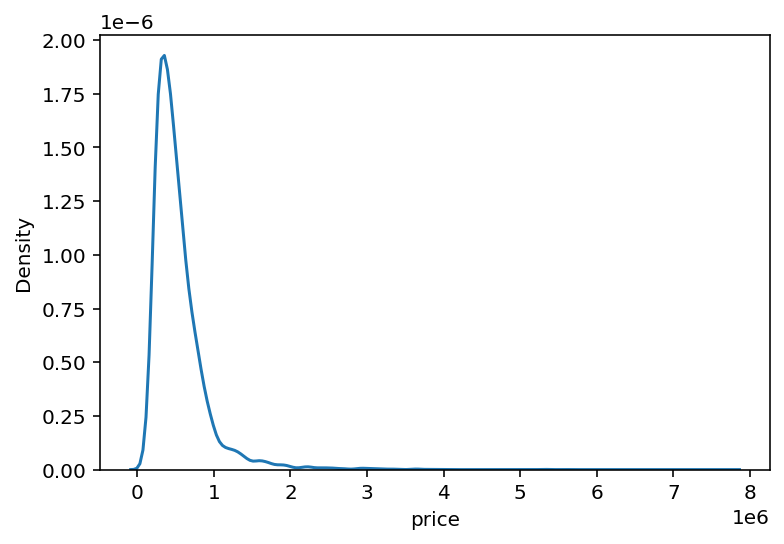

In [12]:
sns.kdeplot(y)
plt.show()

# 낮은 가격에 치우쳐져 있기 때문에 정규화가 필요

In [13]:
y = np.log(y)
y

0        12.309982
1        12.100712
2        13.142166
3        12.458775
4        12.583995
           ...    
15030    13.322337
15031    13.822983
15032    12.793859
15033    12.899220
15034    12.691580
Name: price, Length: 15035, dtype: float64

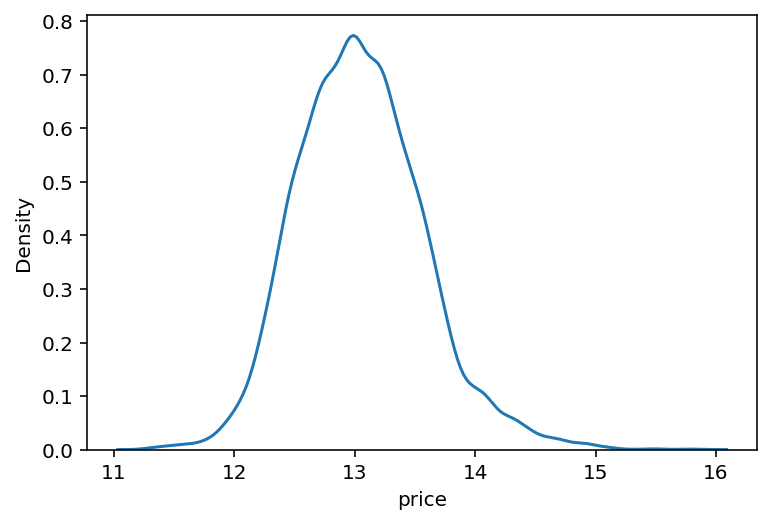

In [14]:
sns.kdeplot(y)
plt.show()

In [15]:
# train 데이터의 자료형 확인

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

### 2. 모델 학습

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [18]:
# RMSE 값을 산출하기 전에, log()데이터를 expm()로 되돌리도록 함수를 저장해둔다.

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [23]:
# 모델 호출

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [28]:
#random_state=None
random_state=2020 # random_state값이 고정되지 않으면 학습결과가 매번 달라지기 때문에, 고정해두고 시작

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [30]:
# 각 모델의 이름을 확인

gboost.__class__.__name__

'GradientBoostingRegressor'

In [32]:
df = {}

for model in models:
    model_name = model.__class__.__name__
    
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    df[model_name] = rmse(y_test, y_pred)
    
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

df

{'GradientBoostingRegressor': 128360.18713010446,
 'XGBRegressor': 110040.41242727595,
 'LGBMRegressor': 111920.36837505356,
 'RandomForestRegressor': 125116.6024716704}

In [33]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.187130
RandomForestRegressor,125116.602472
LGBMRegressor,111920.368375
XGBRegressor,110040.412427


### 3. 하이퍼파라미터 실험해보기

In [34]:
from sklearn.model_selection import GridSearchCV

In [35]:
# xgboost관련 하이퍼 파라미터를 준비

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [36]:
# LightGBM(lgbm) 모델

model = LGBMRegressor(random_state=random_state)

In [38]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                         scoring='neg_mean_squared_error', \
                         cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [39]:
grid_model.cv_results_

{'mean_fit_time': array([1.01254916, 1.17377729, 2.16743603, 3.5298305 ]),
 'std_fit_time': array([0.03183137, 0.17427056, 0.05579376, 0.06331331]),
 'mean_score_time': array([0.05698819, 0.07429724, 0.1584444 , 0.19087715]),
 'std_score_time': array([0.0107269 , 0.01584032, 0.0113167 , 0.0766471 ]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.07569776, -0.05555679, -0.02885862, -0.02665442]),
 'split1_test_score': array([-0.07666484, -0.05787629, -0.03041482, -0.02795911]),
 'split2_test_score': array([-0.0735494 

In [40]:
# 파라미터 조합을 따로 출력

params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [41]:
# 각각의 테스트 점수를 따로 출력

score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339482, -0.0550207 , -0.0291775 , -0.02702729])

In [43]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073395
1,1,100,-0.055021
2,10,50,-0.029177
3,10,100,-0.027027


In [44]:
# 가격예측, Regression에 맞는 성능평가지표를 다시 RMSE로 표시

results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073395,0.270915
1,1,100,-0.055021,0.234565
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164400


In [47]:
# 그리드 탐색에서는 np.expm()과정을 진행하지 않았기 때문에,
# 해당 값은 log변환되어 있는 price데이터에서 손실함수값의 계산에 해당. RMSLE(Root Mean Squared Log Error)에 해당

results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073395,0.270915
1,1,100,-0.055021,0.234565
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164400


In [48]:
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164400
2,10,50,-0.029177,0.170814
1,1,100,-0.055021,0.234565
0,1,50,-0.073395,0.270915


In [49]:
#그리드 탐색을 수행하고 결과를 확인하는 과정을 하나의 함수로 정리

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [50]:
# 그리드 탐색

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164400
2,10,50,-0.029177,0.170814
1,1,100,-0.055021,0.234565
0,1,50,-0.073395,0.270915


[CV] END .......................max_depth=1, n_estimators=50; total time=   1.0s
[CV] END ......................max_depth=10, n_estimators=50; total time=   2.3s
[CV] END .....................max_depth=10, n_estimators=100; total time=   4.1s
[CV] END .......................max_depth=1, n_estimators=50; total time=   1.0s
[CV] END ......................max_depth=1, n_estimators=100; total time=   1.5s
[CV] END ......................max_depth=10, n_estimators=50; total time=   2.6s
[CV] END .....................max_depth=10, n_estimators=100; total time=   3.9s
[CV] END .......................max_depth=1, n_estimators=50; total time=   1.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   1.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   2.3s
[CV] END .....................max_depth=10, n_estimators=100; total time=   4.2s
[CV] END .......................max_depth=1, n_estimators=50; total time=   1.1s
[CV] END ...................

In [51]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580588, 13.08051191, 14.11201992, ..., 13.01592648,
       12.69894666, 12.96297533])

In [52]:
prediction = np.expm1(prediction)
prediction

array([ 506765.63031813,  479505.1080503 , 1345154.1515274 , ...,
        449514.89005445,  327401.85480878,  426331.70805917])

In [53]:
# sample_submission.csv파일 가져와보기

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [54]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067656e+05
1,15036,4.795051e+05
2,15037,1.345154e+06
3,15038,3.122568e+05
4,15039,3.338635e+05


In [55]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


### 그리드탐색을 통해 최적의 조합을 찾아내고, 해당모델로 학습, 예측값을 저장하는 함수를 만든다.

In [56]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

### 결론. 하이퍼 파라미터 튜닝은 최적화 방법 중 하나일 뿐, EDA과정도 매우 중요하다.

1. 내용 중에는 lightgbm만 학습시킨 것 같은데,

다른 모델을 이용한다면 함수 내용을 바꿔야 하는 것인지,

다른 모델을 학습시킬 필요가 없었던 것인지 확인이 필요.



죄송합니다. 몸살 문제로 완성하지 못했습니다.